In [21]:
import pandas as pd
import networkx as nx
import numpy as np
import os

from scipy.spatial.distance import pdist
from scipy import linalg

import matplotlib.pyplot as plt

import re

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

## Data Import

In [2]:
# Fetch the 20 newsgroups dataset
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Create a DataFrame with data and target columns
data = pd.DataFrame({'data': newsgroups_data.data, 
                   'target': newsgroups_data.target, 
                   'target_names': [newsgroups_data.target_names[i] for i in newsgroups_data.target]})

In [23]:
# Function to remove newline characters and notations
def clean_text(text):
    # Remove newline characters and other structural notations
    cleaned_text = text.replace('\n', ' ').replace('<[^>]*>', '').replace('[\W_]+', ' ')
    return cleaned_text

# Define a custom pre-processing function to remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)  # This regex removes all digits

In [4]:
data['data'] = data['data'].apply(clean_text)
data

,data,target,target_names
0,I am sure some bashers of Pens fans are pret...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\tFinally you said what you dream about. M...,17,talk.politics.mideast
3,Think! It's the SCSI card doing the DMA tran...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware
...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye) DN...,13,sci.med
18842,Not in isolated ground recepticles (usually a...,12,sci.electronics
18843,I just installed a DX2-66 CPU in a clone mothe...,3,comp.sys.ibm.pc.hardware
18844,Wouldn't this require a hyper-sphere. In 3-s...,1,comp.graphics


In [10]:
data_df_text = data["data"]
data_df_text

0          I am sure some bashers of Pens fans are pret...
1        My brother is in the market for a high-perform...
2            \tFinally you said what you dream about. M...
3         Think!  It's the SCSI card doing the DMA tran...
4        1)    I have an old Jasmine drive which I cann...
                               ...                        
18841    DN> From: nyeda@cnsvax.uwec.edu (David Nye) DN...
18842     Not in isolated ground recepticles (usually a...
18843    I just installed a DX2-66 CPU in a clone mothe...
18844     Wouldn't this require a hyper-sphere.  In 3-s...
18845    After a tip from Gary Crum (crum@fcom.cc.utah....
Name: data, Length: 18846, dtype: object

In [132]:
labels = data["target"].tolist()
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

## Vectorize Text

In [40]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english', preprocessor=remove_numbers)

# Fit and transform the text data using TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(data_df)

In [136]:
data_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [137]:
data_df

,AX,And,As,But,DOS,For,God,He,How,If,...,time,use,used,using,ve,want,way,work,year,years
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.215082,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.171101,...,0.188987,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.236234
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.103661,0.000000,0.117549,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.000000,0.473250,0.173622,0.0,0.0,0.0,0.0,0.182771,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,0.0,0.406567,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.159064,...,0.175692,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.219615
18842,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
18843,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.37988,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.334547,0.0,0.000000
18844,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [139]:
# data_df.to_csv("tf_idf.csv")

## Proximity

#### Distance Matrix

In [43]:
# Pairwise distances
dimension = data_df.shape[0]
dist_ = pdist(data_df)
dist_mat = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in range(dimension):
    for j in range(i+1, dimension):  
        d = next(dist)
        dist_mat[i,j] = d
        dist_mat[j,i] = d

In [52]:
dist_mat

array([[0.        , 1.41421356, 1.41421356, ..., 1.38675438, 1.41421356,
        1.41421356],
       [1.41421356, 0.        , 1.41421356, ..., 1.41421356, 1.41421356,
        1.41421356],
       [1.41421356, 1.41421356, 0.        , ..., 1.35538187, 1.41421356,
        1.24092486],
       ...,
       [1.38675438, 1.41421356, 1.35538187, ..., 0.        , 1.41421356,
        1.19557573],
       [1.41421356, 1.41421356, 1.41421356, ..., 1.41421356, 0.        ,
        1.41421356],
       [1.41421356, 1.41421356, 1.24092486, ..., 1.19557573, 1.41421356,
        0.        ]])

#### Adjacency/ Similarity Matrix (Self-Tuning Spectral Clustering Algorithm)

In [115]:
#calculate local sigma
sigmas = np.zeros(dimension)
for i in range(len(dist_mat)):
    sigmas[i] = sorted(dist_mat[i])[1376]

In [116]:
sigmas

array([1., 1., 1., ..., 1., 1., 1.])

In [117]:
len(sigmas) - np.count_nonzero(sigmas)

0

In [118]:
# Adjaceny matrix with optimal sigma
adjacency_matrix = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in range(dimension):
    for j in range(i+1, dimension):  
        d = np.exp(-1*next(dist)**2/(sigmas[i]*sigmas[j]))
        adjacency_matrix[i,j] = d
        adjacency_matrix[j,i] = d

In [119]:
adjacency_matrix

array([[0.        , 0.13533528, 0.13533528, ..., 0.14615498, 0.13533528,
        0.13533528],
       [0.13533528, 0.        , 0.13533528, ..., 0.13533528, 0.13533528,
        0.13533528],
       [0.13533528, 0.13533528, 0.        , ..., 0.15928503, 0.13533528,
        0.21440372],
       ...,
       [0.14615498, 0.13533528, 0.15928503, ..., 0.        , 0.13533528,
        0.23945224],
       [0.13533528, 0.13533528, 0.13533528, ..., 0.13533528, 0.        ,
        0.13533528],
       [0.13533528, 0.13533528, 0.21440372, ..., 0.23945224, 0.13533528,
        0.        ]])

## Eigen Decomposition

In [120]:
# Calculate degree matrix
degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

In [121]:
degree_matrix

array([[3198.9072519 ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        , 3014.81344221,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        , 3736.09086609, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 3355.2941845 ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        3101.50975639,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 3466.9710696 ]])

In [122]:
# Normalized laplacian matrix
d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
laplacian_matrix = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

In [123]:
laplacian_matrix

array([[0.00000000e+00, 4.35792740e-05, 3.91472714e-05, ...,
        4.46115690e-05, 4.29658726e-05, 4.06382599e-05],
       [4.35792740e-05, 0.00000000e+00, 4.03247886e-05, ...,
        4.25515626e-05, 4.42582501e-05, 4.18606248e-05],
       [3.91472714e-05, 4.03247886e-05, 0.00000000e+00, ...,
        4.49884420e-05, 3.97571959e-05, 5.95728649e-05],
       ...,
       [4.46115690e-05, 4.25515626e-05, 4.49884420e-05, ...,
        0.00000000e+00, 4.19526268e-05, 7.02066879e-05],
       [4.29658726e-05, 4.42582501e-05, 3.97571959e-05, ...,
        4.19526268e-05, 0.00000000e+00, 4.12714143e-05],
       [4.06382599e-05, 4.18606248e-05, 5.95728649e-05, ...,
        7.02066879e-05, 4.12714143e-05, 0.00000000e+00]])

In [124]:
# Calculating eigenvalues and eigenvectors

e, v = np.linalg.eigh(laplacian_matrix)

In [125]:
# Eigenvalues
e

array([-3.46484372e-04, -3.46484372e-04, -3.46484372e-04, ...,
        5.30536115e-02,  6.79841268e-02,  1.00000000e+00])

In [126]:
# Eigenvectors
v

array([[-7.37844435e-16,  0.00000000e+00,  0.00000000e+00, ...,
         9.70707767e-04, -3.50766711e-03, -6.78720178e-03],
       [-1.80447227e-13,  8.29982699e-14, -2.21907878e-13, ...,
        -3.33370081e-03, -4.83371976e-03, -6.58900987e-03],
       [-1.26759091e-14,  3.48233082e-15, -6.84413424e-15, ...,
         1.13880062e-02,  4.34345457e-03, -7.33497523e-03],
       ...,
       [-1.60132551e-16, -2.17909183e-16,  7.87831242e-16, ...,
         3.75987793e-03, -1.28361513e-03, -6.95112724e-03],
       [ 4.72833024e-16,  5.84251156e-16,  1.05428306e-15, ...,
        -1.66003970e-04, -1.61927857e-03, -6.68307773e-03],
       [-5.44697940e-16,  2.60094508e-16, -4.67494209e-17, ...,
        -1.67410597e-03,  4.50811372e-04, -7.06586028e-03]])

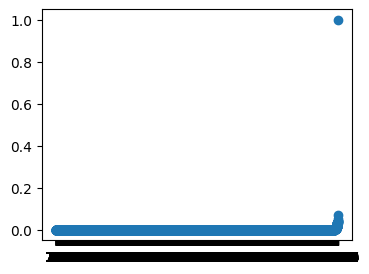

In [127]:
# Plotting the eigenvalues
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(range(len(e)), e);
plt.xticks(range(0,len(e)));

In [128]:
# Gaps in eigenvalues
gaps = np.diff(e)
eigen_gap_df = pd.DataFrame({'Index': range(len(e) - 1), 'Gap': gaps})
eigen_gap_df.sort_values(by='Gap', ascending=False, inplace=True)

In [129]:
eigen_gap_df

,Index,Gap
18844,18844,0.932016
18843,18843,0.014931
18842,18842,0.009783
18746,18746,0.003999
18840,18840,0.003285
...,...,...
1700,1700,0.000000
1701,1701,0.000000
1702,1702,0.000000
14437,14437,0.000000


In [130]:
eigen_gap_df[eigen_gap_df['Index'] < 30]

,Index,Gap
14,14,8.717233e-06
13,13,1.335218e-06
19,19,7.474515e-07
26,26,2.888426e-07
15,15,2.471307e-07
29,29,1.080603e-07
21,21,1.002729e-07
20,20,4.233686e-08
12,12,3.686809e-08
22,22,3.241522e-08


In [133]:
# Eigen features for k
k = 20
X = v[:, -1*k:]
# row_sums = X.sum(axis=1)
# Y = X / row_sums[:, np.newaxis]

## Clustering

In [134]:
cluster_df = pd.DataFrame(X)
cluster_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.002964,-0.002771,0.000300,-0.003477,0.002338,-0.000203,0.007653,-0.000788,0.002300,-0.003928,0.001856,-0.003215,-0.008944,0.002983,-0.000895,0.005773,-0.002132,0.000971,-0.003508,-0.006787
1,0.001323,0.001117,-0.002042,-0.001252,0.001861,-0.000767,-0.002110,0.000440,0.000949,0.001880,0.000653,0.000471,-0.000123,0.000250,-0.001237,0.004141,-0.002409,-0.003334,-0.004834,-0.006589
2,-0.005133,0.006540,0.008235,0.003071,-0.001357,-0.000223,-0.011841,0.006861,0.005549,0.001351,0.001529,-0.002874,-0.000569,0.005454,-0.003011,-0.009679,0.000061,0.011388,0.004343,-0.007335
3,0.011852,-0.000376,0.001177,0.005369,-0.001981,0.006035,0.001286,0.000674,0.001505,-0.001396,-0.005219,0.000026,0.004988,0.001211,0.006861,0.004983,-0.001445,-0.005079,-0.000209,-0.006759
4,-0.001704,-0.010440,0.003476,-0.000748,-0.003410,0.011914,0.007622,0.008776,0.001869,-0.001948,0.022047,0.027081,0.017618,0.015577,0.010168,-0.006318,-0.009040,-0.004620,-0.004659,-0.006959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,0.003227,-0.001878,-0.002961,-0.002972,-0.005835,-0.001031,-0.009060,-0.004585,-0.010559,0.001978,0.004678,-0.001537,-0.006453,0.006374,-0.001259,-0.006818,0.013012,0.018060,0.001434,-0.007338
18842,0.001661,-0.005336,-0.010934,0.005003,0.003847,0.013267,0.000825,-0.002355,0.003202,0.002699,-0.006507,0.000563,0.004649,0.004087,0.005027,0.004077,-0.003644,-0.005285,-0.002873,-0.006682
18843,0.003396,0.003487,-0.002387,-0.000682,0.009187,-0.003954,0.008004,-0.005250,0.000600,0.001845,0.003313,0.000126,-0.000018,-0.000134,0.009794,0.002378,0.000352,0.003760,-0.001284,-0.006951
18844,0.006123,0.002580,-0.000686,0.000876,-0.000403,0.001504,0.000845,0.002734,-0.001222,0.001576,-0.002662,-0.001774,0.001724,-0.001992,-0.003052,0.006579,-0.000021,-0.000166,-0.001619,-0.006683


In [138]:
clustering = KMeans(n_clusters = 20)
clustering.fit(cluster_df)

cluster_labels = clustering.labels_
print(silhouette_score(data_df, cluster_labels),adjusted_rand_score(labels, cluster_labels))

C:\Users\mondal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.04831378783017823 0.025290887697658367
